<a href="https://colab.research.google.com/github/Jarvis-BITS/midodrine-mimic-iv/blob/demo/Midodrine_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[BigQuery data extraction](#scrollTo=jGzHNqjcJ0Sb)

>[Building cohort table](#scrollTo=h5MDsnO06pon)

>>[Extract population info](#scrollTo=EzBHdluYIsxb)

>>[Building the cohort table (consisting of only ICU patients)](#scrollTo=J4qxmGbGMFl4)

>>[Extract the weight](#scrollTo=UBNF-pxOaa4p)

>>[Extract the basic score (charlson, sapsii)](#scrollTo=jPeTNsOnT-mE)

>>[Extract the modality](#scrollTo=vlPR5l-IUgiO)

>>[Extract the Comorbidities](#scrollTo=XKXHT4cUamOu)

>>[Extract Vital Signs](#scrollTo=ynCiC9p6bCRZ)

>>[Extract Lab Tests Results](#scrollTo=jOdRATEybzrt)

>>[Extract interventions](#scrollTo=rL06xYZyg_uk)

>>[Divide the Midodrine Group](#scrollTo=f7vKuA38eprQ)

>>[Divide the Non-Midodrine Group](#scrollTo=aU1W-Ifkh9qx)

>>[Integrate the feature](#scrollTo=kJlb2nrDk6xs)

>[Propensity score matching](#scrollTo=PsjK-gZo2JUw)

>>>[First method](#scrollTo=LIamJD76DE2a)

>>>[Second way](#scrollTo=ZaX5oerHDWez)

>>>[Third Way](#scrollTo=B1NpfqYTHQpc)

>>[TMLE on unweighted cohort](#scrollTo=zfaRzkVOx0Xd)

>>[Extract matched no-midodrine data](#scrollTo=8xgcjsBSQ7yi)

>>[Save the results](#scrollTo=EpkwjvgMFbP2)



Import libraries

In [ ]:
!pip install psmpy
!pip install pysmatch
!pip install causalml
!pip install xgboost
!pip install zepid
!pip install rpy2

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from google.cloud import bigquery
from causalml import match
from pysmatch.Matcher import Matcher
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
from  xgboost import XGBClassifier
from zepid import (RiskDifference, RiskRatio, OddsRatio, NNT,
                   IncidenceRateRatio, IncidenceRateDifference)
from zepid.superlearner import GLMSL, StepwiseSL, SuperLearner
from zepid.causal.doublyrobust import TMLE, SingleCrossfitAIPTW, SingleCrossfitTMLE
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter 
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

Check to see if GPU connected. 
It is advised to add GPU from Runtime<Change runtime type<Hardware Accelaration<GPU for faster processing speeds

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Authenticate with GCP account having MIMIC-IV dataset

In [4]:
from google.colab import auth

auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
%load_ext google.colab.data_table

In [6]:
%load_ext google.cloud.bigquery

In [7]:
project_id = 'mit-midodrine' #Enter your project ID from GCP bigquey here
bqclient = bigquery.Client(project=project_id)

# BigQuery data extraction

In [8]:
population_string = """
WITH patient_details AS (
  SELECT
  ie.subject_id, ie.hadm_id, ie.stay_id
  , pat.gender, pat.dod
  , adm.admittime, adm.dischtime
  , DATETIME_DIFF(adm.dischtime, adm.admittime, DAY) AS los_hospital
  , pat.anchor_age
  , DATETIME_DIFF(adm.admittime, DATETIME(pat.anchor_year, 1, 1, 0, 0, 0), YEAR) + pat.anchor_age AS age
  , adm.ethnicity
  , adm.hospital_expire_flag

-- icu level factors
  , ie.intime AS icu_intime, ie.outtime AS icu_outtime
  , ROUND(DATETIME_DIFF(ie.outtime, ie.intime, HOUR)/24.0, 2) AS los_icu
  , RANK() OVER (PARTITION BY adm.subject_id ORDER BY ie.intime) AS icu_order

  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_core.admissions` adm
  ON ie.hadm_id = adm.hadm_id
  INNER JOIN `physionet-data.mimic_core.patients` pat
  ON ie.subject_id = pat.subject_id
  )
  , midodrine AS (
    SELECT hadm_id, starttime AS drug_starttime
    FROM `physionet-data.mimic_hosp.pharmacy`
    WHERE lower(medication) like 'midodrine'
  )
  , midodrine_exclude AS (
    SELECT stay_id,
    CASE WHEN LOGICAL_AND(drug_starttime < DATE_TRUNC(intime - interval '1' day, DAY) OR drug_starttime > outtime) THEN 1 
    ELSE 0 END AS midodrine_exclude
    FROM `physionet-data.mimic_icu.icustays` 
    LEFT JOIN midodrine USING (hadm_id)
    GROUP BY stay_id
  )
  , midodrine_include AS (
    SELECT stay_id,
    CASE WHEN LOGICAL_AND(drug_starttime is NULL)
    OR LOGICAL_OR(drug_starttime BETWEEN DATE_TRUNC(intime - interval '1' day, DAY) AND outtime) THEN 1
    ELSE 0 END AS midodrine_include
    FROM `physionet-data.mimic_icu.icustays`  
    LEFT JOIN midodrine USING (hadm_id)
    GROUP BY stay_id
  )
  , midodrine_first AS (
  SELECT stay_id, min(drug_starttime) AS drug_starttime 
  FROM `physionet-data.mimic_icu.icustays` LEFT JOIN midodrine mi USING (hadm_id)
  WHERE drug_starttime BETWEEN DATE_TRUNC(intime - interval '1' day, DAY) AND outtime
  GROUP BY stay_id
  )
 , midodrine_dose AS (
  SELECT ic.stay_id, AVG(doses_per_24_hrs) AS avg_doses_per_24_hrs
  FROM `physionet-data.mimic_hosp.pharmacy` ph
  INNER JOIN `physionet-data.mimic_icu.icustays`ic
  ON ph.hadm_id = ic.hadm_id
  GROUP BY ic.stay_id
  )
  , adm_weekday AS (
    SELECT stay_id,
      EXTRACT(DAYOFWEEK FROM intime) AS adm_weekday
    FROM `physionet-data.mimic_icu.icustays`
  )
  , population AS (
    SELECT * 
    FROM (SELECT DISTINCT stay_id, first_careunit, intime, outtime FROM `physionet-data.mimic_icu.icustays`) a
    LEFT JOIN patient_details USING (stay_id)
    LEFT JOIN midodrine_first USING (stay_id)
    LEFT JOIN midodrine_exclude USING (stay_id)
    LEFT JOIN midodrine_include USING (stay_id)
    LEFT JOIN midodrine_dose USING (stay_id)
    LEFT JOIN adm_weekday USING (stay_id)
    )
    SELECT * FROM population
"""

In [9]:
cohort_string = """
, cohort AS(
  SELECT *
    ,CASE WHEN drug_starttime is null THEN 1 ELSE 0 END AS drug
  FROM population
  WHERE age >= 18
    AND icu_order = 1
    AND (first_careunit LIKE '%MICU%' OR first_careunit LIKE '%SICU%')
    AND midodrine_include = 1
)
SELECT * FROM cohort
"""

In [10]:
basic_string = """
WITH sapsii AS (
  SELECT sa.stay_id
    , AVG(sa.sapsii) AS sapsii
  FROM `physionet-data.mimic_derived.sapsii` sa
  LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
  WHERE
    (sa.starttime BETWEEN DATE_TRUNC(ic.intime - interval '1' day, DAY) AND ic.outtime)
    AND (sa.endtime < ic.outtime)
  GROUP BY stay_id
)
, charlson AS(
  SELECT ic.stay_id
    , AVG(chr.charlson_comorbidity_index) AS charlson_index
  FROM `physionet-data.mimic_derived.charlson` chr
  LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (subject_id)
  GROUP BY ic.stay_id
)
, basic AS (
  SELECT *
  FROM (SELECT DISTINCT stay_id FROM `physionet-data.mimic_icu.icustays`) a
  LEFT JOIN sapsii USING (stay_id)
  LEFT JOIN charlson USING (stay_id)
)
SELECT * FROM basic
"""

In [11]:
modality_string = """
SELECT ic.stay_id,
  MAX(CASE WHEN pa.dod is not null THEN 1 ELSE 0 END) AS modality,
FROM `physionet-data.mimic_core.patients` pa
LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (subject_id)
GROUP BY ic.stay_id
"""

In [12]:
comorbidities_string = """
WITH charlson AS(
  SELECT subject_id, hadm_id
  , renal_diseASe AS Renal
  , severe_liver_diseASe AS severe_liver
  , mild_liver_diseASe AS mild_liver
  , chronic_pulmonary_diseASe AS CPD_or_COPD
  , malignant_cancer AS Maligancy
  FROM `physionet-data.mimic_derived.charlson` char
)
, diag AS
(
  SELECT 
      hadm_id
      , CASE WHEN icd_version = 9 THEN icd_code ELSE NULL END AS icd9_code
      , CASE WHEN icd_version = 10 THEN icd_code ELSE NULL END AS icd10_code
  FROM `physionet-data.mimic_hosp.diagnoses_icd` diag
)
, addition AS(
  SELECT ad.hadm_id
  -- CAD
  , MAX(CASE WHEN
      icd9_code LIKE '414%'
      OR
      SUBSTR(icd10_code, 1, 4) = 'I251'
      THEN 1 
      ELSE 0 END) AS CAD
  -- AFIB
  , MAX(CASE WHEN
      icd9_code LIKE '4273%'
      OR
      SUBSTR(icd10_code, 1, 3) = 'I48'
      THEN 1 
      ELSE 0 END) AS AFIB
  FROM `physionet-data.mimic_core.admissions` ad
  LEFT JOIN diag
  ON ad.hadm_id = diag.hadm_id
  GROUP BY ad.hadm_id
)
, comorbidities AS(
  SELECT ic.stay_id
    , AVG(charlson.CPD_or_COPD) AS CPD_or_COPD_rate
    , AVG(charlson.Maligancy) AS Maligancy_rate
    , AVG(charlson.mild_liver) AS mild_liver_rate
    , AVG(charlson.severe_liver) AS severe_liver_rate
    , AVG(charlson.Renal) AS Renal_rate
    , AVG(addition.CAD) AS CAD_rate
    , AVG(addition.AFIB) AS AFIB_rate
  FROM `physionet-data.mimic_icu.icustays` ic
  LEFT JOIN charlson USING (hadm_id)
  LEFT JOIN addition USING (hadm_id)
  GROUP BY ic.stay_id
)
SELECT * FROM comorbidities
"""

In [13]:
weight_string = """
SELECT * FROM `physionet-data.mimic_derived.weight_durations`
"""

In [14]:
vital_sign_string = """
WITH vital_signs_cohort AS(
  SELECT vital.stay_id
    , AVG(vital.temperature) AS temperature_mean, AVG(vital.heart_rate) AS heart_rate_mean, AVG(vital.resp_rate) AS resp_rate_mean, AVG(vital.mbp) AS mbp_mean
  FROM `physionet-data.mimic_derived.vitalsign` vital
  LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
  WHERE vital.charttime BETWEEN DATETIME_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
  GROUP BY vital.stay_id
)
SELECT * FROM vital_signs_cohort
"""

In [15]:
lab_tests_string = """
WITH blood AS (
  SELECT ic.stay_id
    , AVG(hemoglobin) AS hemoglobin
    , AVG(platelet) AS platelet
    , AVG(wbc) AS wbc
  FROM `physionet-data.mimic_derived.complete_blood_count` cbc
  LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (hadm_id)
  WHERE cbc.charttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
  GROUP BY ic.stay_id
)
, chem AS (
  SELECT ic.stay_id
    , AVG(sodium) AS sodium
    , AVG(potassium) AS potassium
    , AVG(bicarbonate) AS bicarbonate
    , AVG(chloride) AS chloride
    , AVG(bun) AS bun
    , AVG(creatinine) AS creatinine
  FROM `physionet-data.mimic_derived.chemistry` chem
  LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (hadm_id)
  WHERE chem.charttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
  GROUP BY ic.stay_id
)
, bg AS (
  SELECT ic.stay_id
     , AVG(lactate) AS lactate
     , AVG(ph) AS ph
     , AVG(po2) AS po2
     , AVG(pco2) AS pco2
  FROM  `physionet-data.mimic_derived.bg` bg
  LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (hadm_id)
  WHERE bg.charttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
  GROUP BY ic.stay_id
)
, logical_tested_index AS (
  SELECT ic.stay_id
    , AVG(CASE WHEN ntprobnp is not null THEN 1 ELSE 0 END) AS bnp
    , AVG(CASE WHEN troponin_t is not null THEN 1 ELSE 0 END)AS troponin
    , AVG(CASE WHEN ck_mb is not null THEN 1 ELSE 0 END) AS creatinine_kinase
  FROM `physionet-data.mimic_derived.cardiac_marker` cm
  LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (hadm_id)
  WHERE cm.charttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
  GROUP BY ic.stay_id
)
, lab_tests AS (
  SELECT ic.stay_id
    , blood.hemoglobin, blood.platelet, blood.wbc
    , chem.sodium, chem.potassium, chem.bicarbonate, chem.chloride, chem.bun, chem.creatinine
    , bg.lactate, bg.ph, bg.po2, bg.pco2
    , lti.bnp, lti.troponin, lti.creatinine_kinase
  
  FROM `physionet-data.mimic_icu.icustays` ic
  LEFT JOIN blood USING (stay_id)
  LEFT JOIN chem USING (stay_id)
  LEFT JOIN bg USING (stay_id)
  LEFT JOIN logical_tested_index lti USING (stay_id)
)
SELECT * FROM lab_tests
"""

In [16]:
interventions_string = """
-- sedative extract
WITH sedative AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ip.itemid in (221668,221744,225972,225942,222168) THEN 1 ELSE 0 END) AS sedative_use
    FROM `physionet-data.mimic_icu.icustays` ic
    LEFT JOIN `physionet-data.mimic_icu.inputevents` ip USING (stay_id)
    WHERE ip.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)

-- vasopressor
, vasopressin AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.vasopressin`) THEN 1 ELSE 0 END) AS vasopressin_use
    FROM `physionet-data.mimic_derived.vasopressin` iv
    LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE iv.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, dobutamine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.dobutamine`) THEN 1 ELSE 0 END) AS dobutamine_use
    FROM `physionet-data.mimic_derived.dobutamine` idb
    LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE idb.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, dopamine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.dopamine`) THEN 1 ELSE 0 END) AS dopamine_use
    FROM `physionet-data.mimic_derived.dopamine` idp
    LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE idp.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, epinephrine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.epinephrine`) THEN 1 ELSE 0 END) AS epinephrine_use
    FROM `physionet-data.mimic_derived.epinephrine` iep
    LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE iep.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, milrinone AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.milrinone`) THEN 1 ELSE 0 END) AS milrinone_use
    FROM `physionet-data.mimic_derived.milrinone` iml
    LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE iml.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, norepinephrine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.norepinephrine`) THEN 1 ELSE 0 END) AS norepinephrine_use
    FROM `physionet-data.mimic_derived.norepinephrine` inrp
    LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE inrp.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, phenylephrine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.phenylephrine`) THEN 1 ELSE 0 END) AS phenylephrine_use
    FROM `physionet-data.mimic_derived.phenylephrine` iphe
    LEFT JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE iphe.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)

-- ventilation
, ventilation AS (
  SELECT ic.stay_id
    , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.ventilation`) THEN 1 ELSE 0 END) AS ventilation_use
    FROM `physionet-data.mimic_icu.icustays` ic
    LEFT JOIN `physionet-data.mimic_derived.ventilation` ivn USING (stay_id)
    WHERE ivn.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)

, interventions as (
    SELECT *
    FROM (SELECT DISTINCT stay_id FROM `physionet-data.mimic_icu.icustays`) a
    LEFT JOIN sedative USING (stay_id)
    LEFT JOIN vasopressin USING (stay_id)
    LEFT JOIN ventilation USING (stay_id)
    LEFT JOIN dobutamine USING (stay_id)
    LEFT JOIN dopamine USING (stay_id)
    LEFT JOIN epinephrine USING (stay_id)
    LEFT JOIN milrinone USING (stay_id)
    LEFT JOIN norepinephrine USING (stay_id)
    LEFT JOIN phenylephrine USING (stay_id)
)

SELECT * FROM interventions;
"""

# Building cohort table

## Extract population info

In [17]:
population_data = (
    bqclient.query(population_string)
    .result()
    .to_dataframe()
)

In [18]:
#population_data[population_data['age']>91]['age']=91
population_data['age'].mask(population_data['age'] > 89, 91, inplace=True)

## Building the cohort table (consisting of only ICU patients)
1. Include adults (>= 18 years' old)
2. Include the first ICU admission of each patient
3. Include patients whose ICU care is 'MICU' or 'SICU'
4. Exclude those who accepted midodrine more than one day before icu care or after icu care (have been done before)

Note: midodrine_inlcude is just opposite of midodrine_exclude so use either of the two for this

In [19]:
cohort_data = (
    bqclient.query(population_string[:-25]+cohort_string)
    .result()
    .to_dataframe()
)

In [20]:
#cohort_data[cohort_data['age']>91]['age'] = 91
cohort_data['age'].mask(cohort_data['age'] > 89, 91, inplace=True)

## Extract the weight

In [21]:
weight_data = (
    bqclient.query(weight_string)
    .result()
    .to_dataframe()
)

In [22]:
weight_data

,stay_id,starttime,endtime,weight,weight_type
0,35461582,2125-02-28 09:28:38,2125-03-05 17:53:07,2.000,admit
1,34293265,2128-10-31 01:30:00,2128-10-31 15:00:00,4.000,admit
2,34050270,2168-07-10 15:26:52,2168-07-12 03:00:00,6.500,admit
3,31130982,2178-08-05 02:04:00,2178-08-05 04:00:00,10.000,admit
4,36422433,2177-09-15 19:52:38,2177-09-17 19:44:16,10.000,admit
...,...,...,...,...,...
287150,31737400,2137-09-07 08:00:00,2137-09-08 08:00:00,39.045,daily
287151,37414585,2138-03-22 11:00:00,2138-03-23 05:00:00,133.180,daily
287152,38075991,2132-03-26 21:00:00,2132-03-27 17:03:53,74.840,daily
287153,30431706,2154-02-07 22:15:00,2154-02-10 06:00:00,111.090,daily


## Extract the basic score (charlson, sapsii)

In [23]:
basic_data = (
    bqclient.query(basic_string)
    .result()
    .to_dataframe()
)

In [24]:
basic_data

,stay_id,sapsii,charlson_index
0,34338479,8.0,0.000000
1,37186192,61.0,7.666667
2,37535351,10.0,2.000000
3,31860020,8.0,2.000000
4,38476338,16.0,5.600000
...,...,...,...
76535,30852106,57.0,6.461538
76536,33069153,57.0,11.222222
76537,35524095,57.0,6.000000
76538,39130941,57.0,2.840000


## Extract the modality

In [25]:
modality_data = (
    bqclient.query(modality_string)
    .result()
    .to_dataframe()
)

In [26]:
modality_data

,stay_id,modality
0,32541787.0,0
1,30880402.0,0
2,39132918.0,0
3,32764467.0,0
4,31529823.0,0
...,...,...
76536,34482476.0,1
76537,34190933.0,1
76538,38571261.0,1
76539,31461797.0,1


## Extract the Comorbidities

In [27]:
comorbidities_data = (
    bqclient.query(comorbidities_string)
    .result()
    .to_dataframe()
)

In [28]:
comorbidities_data.describe()

,stay_id,CPD_or_COPD_rate,Maligancy_rate,mild_liver_rate,severe_liver_rate,Renal_rate,CAD_rate,AFIB_rate
count,7.654000e+04,76540.000000,76540.000000,76540.000000,76540.000000,76540.000000,76540.000000,76540.000000
mean,3.499480e+07,0.259211,0.131761,0.119036,0.055344,0.218853,0.293977,0.294617
std,2.888755e+06,0.438204,0.338233,0.323833,0.228651,0.413471,0.455585,0.455873
min,3.000015e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.249232e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.499660e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.749222e+07,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3.999981e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Extract Vital Signs

In [29]:
vital_sign_data = (
    bqclient.query(vital_sign_string)
    .result()
    .to_dataframe()
)

In [30]:
vital_sign_data

,stay_id,temperature_mean,heart_rate_mean,resp_rate_mean,mbp_mean
0,32934723,36.987742,96.388889,15.980315,80.059055
1,38373040,36.391071,71.244898,12.372054,89.084000
2,31747890,37.823725,118.714286,29.631868,93.715084
3,32494377,36.973731,88.128676,18.135531,77.631868
4,38939859,37.896344,97.182336,22.208451,74.644578
...,...,...,...,...,...
76523,37327512,NaN,103.000000,24.000000,NaN
76524,31199714,NaN,72.000000,24.000000,NaN
76525,36433705,NaN,66.000000,24.000000,NaN
76526,33903066,NaN,114.000000,25.000000,103.000000


## Extract Lab Tests Results

In [31]:
lab_tests_data = (
    bqclient.query(lab_tests_string)
    .result()
    .to_dataframe()
)

In [32]:
lab_tests_data

,stay_id,hemoglobin,platelet,wbc,sodium,potassium,bicarbonate,chloride,bun,creatinine,lactate,ph,po2,pco2,bnp,troponin,creatinine_kinase
0,31751864,8.775000,272.750000,9.32500,140.000000,4.300000,23.500000,103.750000,42.500000,1.675000,NaN,NaN,NaN,NaN,0.000000,0.833333,0.666667
1,38690211,12.066667,221.166667,12.40000,138.600000,3.660000,22.400000,102.600000,21.833333,1.216667,NaN,NaN,NaN,NaN,0.000000,0.833333,1.000000
2,30571173,9.850000,163.250000,5.07500,137.000000,4.625000,32.250000,95.250000,30.750000,1.275000,NaN,NaN,NaN,NaN,0.200000,0.600000,0.600000
3,32423515,13.460000,167.600000,7.32000,142.375000,4.050000,23.875000,105.000000,11.125000,0.712500,NaN,NaN,NaN,NaN,0.000000,0.600000,1.000000
4,30399955,15.040000,163.200000,11.38000,136.500000,4.033333,23.333333,100.666667,13.500000,1.216667,NaN,NaN,NaN,NaN,0.000000,0.333333,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,33548341,13.000000,178.666667,11.00000,142.666667,3.566667,25.666667,108.000000,8.666667,0.700000,1.500000,7.490000,154.000000,36.000000,0.000000,0.666667,1.000000
76536,37904621,9.300000,463.500000,12.65000,139.833333,3.814286,26.333333,101.666667,18.500000,1.066667,NaN,7.428333,130.666667,40.666667,0.333333,0.666667,0.666667
76537,38109349,7.712500,262.125000,9.31875,136.666667,4.047619,28.190476,98.666667,18.571429,1.085714,2.070000,7.364706,50.352941,52.411765,0.666667,0.666667,0.666667
76538,39446578,10.370000,270.900000,31.28000,143.000000,4.000000,22.181818,108.818182,23.818182,1.490909,4.550000,7.300000,122.000000,49.500000,0.333333,0.666667,0.333333


## Extract interventions

In [33]:
interventions_data = (
    bqclient.query(interventions_string)
    .result()
    .to_dataframe()
)
interventions_data.fillna(0, inplace=True)

In [34]:
interventions_data['vasopressor_use_sum'] = interventions_data['vasopressin_use'] + interventions_data['dobutamine_use'] + interventions_data['dopamine_use'] + interventions_data['epinephrine_use'] + interventions_data['milrinone_use'] + interventions_data['norepinephrine_use'] + interventions_data['phenylephrine_use']
interventions_data['vasopressor_use'] = (interventions_data['vasopressor_use_sum'] != 0).astype(np.int32)

In [35]:
interventions_data

,stay_id,sedative_use,vasopressin_use,ventilation_use,dobutamine_use,dopamine_use,epinephrine_use,milrinone_use,norepinephrine_use,phenylephrine_use,vasopressor_use_sum,vasopressor_use
0,34547665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,39289362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,32563675,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,34947848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,37445058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
76535,39980385,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
76536,39985296,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
76537,39987031,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
76538,39989040,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Divide the Midodrine Group

In [36]:
cohort_mid = cohort_data[pd.notnull(cohort_data['drug_starttime'])]
cohort_mid.describe()

,stay_id,subject_id,hadm_id,los_hospital,anchor_age,age,hospital_expire_flag,los_icu,icu_order,midodrine_exclude,midodrine_include,avg_doses_per_24_hrs,adm_weekday,drug
count,8.100000e+02,8.100000e+02,8.100000e+02,810.000000,810.000000,810.000000,810.000000,810.000000,810.0,810.0,810.0,810.000000,810.000000,810.0
mean,3.492571e+07,1.506504e+07,2.513436e+07,21.497531,61.655556,62.761728,0.322222,10.107864,1.0,0.0,1.0,1.627904,3.886420,0.0
std,2.896935e+06,2.836112e+06,2.970905e+06,18.881076,14.922499,15.049774,0.467616,11.504315,0.0,0.0,0.0,0.291719,1.962425,0.0
min,3.003771e+07,1.000892e+07,2.000173e+07,0.000000,18.000000,18.000000,0.000000,0.130000,1.0,0.0,1.0,0.985075,1.000000,0.0
25%,3.236288e+07,1.266337e+07,2.243435e+07,8.000000,51.250000,53.000000,0.000000,2.830000,1.0,0.0,1.0,1.446547,2.000000,0.0
50%,3.490289e+07,1.496978e+07,2.541225e+07,16.000000,63.000000,63.000000,0.000000,5.830000,1.0,0.0,1.0,1.578947,4.000000,0.0
75%,3.736149e+07,1.746826e+07,2.782586e+07,29.000000,72.750000,73.000000,1.000000,13.410000,1.0,0.0,1.0,1.758242,5.000000,0.0
max,3.999923e+07,1.999930e+07,2.999661e+07,193.000000,91.000000,91.000000,1.000000,99.630000,1.0,0.0,1.0,4.653061,7.000000,0.0


In [37]:
mid_weights = weight_data[(weight_data['stay_id'].isin(cohort_mid['stay_id'].values)) & (weight_data['weight_type']=='admit')]
mid_weights.describe()

,stay_id,weight
count,7.810000e+02,781.000000
mean,3.494998e+07,84.899872
std,2.910323e+06,26.257020
min,3.003771e+07,32.900000
25%,3.235555e+07,67.700000
50%,3.492028e+07,80.600000
75%,3.743279e+07,98.400000
max,3.999923e+07,230.000000


In [38]:
mid_vital_signs = vital_sign_data[vital_sign_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_vital_signs.describe()

,stay_id,temperature_mean,heart_rate_mean,resp_rate_mean,mbp_mean
count,8.100000e+02,808.000000,810.000000,810.000000,810.000000
mean,3.492571e+07,36.790786,84.924612,19.286474,72.347926
std,2.896935e+06,0.384468,13.817980,3.628422,9.226079
min,3.003771e+07,35.220000,47.952830,10.192308,47.479167
25%,3.236288e+07,36.590974,75.063061,16.770041,66.657449
50%,3.490289e+07,36.777413,85.395760,19.100934,71.635066
75%,3.736149e+07,36.983953,94.941119,21.469442,77.035680
max,3.999923e+07,38.130000,124.914634,48.000000,124.362637


In [39]:
mid_labs = lab_tests_data[lab_tests_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_labs.fillna({'bnp':0, 'troponin':0, 'creatinine_kinase':0}, inplace=True)
mid_labs.describe()

,stay_id,hemoglobin,platelet,wbc,sodium,potassium,bicarbonate,chloride,bun,creatinine,lactate,ph,po2,pco2,bnp,troponin,creatinine_kinase
count,8.100000e+02,805.000000,806.000000,806.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,648.000000,684.000000,684.000000,684.000000,810.000000,810.000000,810.000000
mean,3.492571e+07,9.205536,161.222140,12.477541,137.729635,4.141906,22.478938,102.084150,39.560938,2.281318,2.415392,7.371469,97.063678,40.366431,0.056430,0.307024,0.339251
std,2.896935e+06,1.459199,108.758313,6.455160,5.080456,0.490859,4.525356,6.289177,27.033225,1.848305,1.666055,0.066215,46.085147,8.619284,0.209051,0.443991,0.450604
min,3.003771e+07,6.550000,13.285714,0.733333,115.071429,3.000000,10.277778,73.500000,3.800000,0.106667,0.400000,7.122857,19.000000,20.250000,0.000000,0.000000,0.000000
25%,3.236288e+07,8.108333,75.872024,7.927841,135.000000,3.806232,19.430769,98.178125,18.226959,0.869035,1.495161,7.328807,64.107143,34.816176,0.000000,0.000000,0.000000
50%,3.490289e+07,8.900000,135.444444,11.280000,138.000000,4.100000,22.435484,102.250000,33.714286,1.777778,2.000000,7.375329,92.679438,39.038462,0.000000,0.000000,0.000000
75%,3.736149e+07,9.976923,218.960648,15.612987,141.000000,4.396667,25.111280,105.736111,53.507143,3.009809,2.725893,7.415604,116.561441,44.458333,0.000000,1.000000,1.000000
max,3.999923e+07,15.291667,796.000000,67.900000,154.454545,6.360000,41.684211,121.857143,177.500000,12.300000,16.456250,7.570000,389.000000,81.254902,1.000000,1.000000,1.000000


In [40]:
mid_comorbidities = comorbidities_data[comorbidities_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_comorbidities.describe()

,stay_id,CPD_or_COPD_rate,Maligancy_rate,mild_liver_rate,severe_liver_rate,Renal_rate,CAD_rate,AFIB_rate
count,8.100000e+02,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000
mean,3.492571e+07,0.230864,0.162963,0.495062,0.416049,0.306173,0.162963,0.312346
std,2.896935e+06,0.421646,0.369560,0.500285,0.493206,0.461187,0.369560,0.463736
min,3.003771e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.236288e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.490289e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.736149e+07,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,3.999923e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
mid_basic = basic_data[basic_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_basic.describe()

,stay_id,sapsii,charlson_index
count,8.100000e+02,762.000000,810.000000
mean,3.492571e+07,44.695538,6.290540
std,2.896935e+06,13.951454,2.607063
min,3.003771e+07,11.000000,0.000000
25%,3.236288e+07,35.000000,4.500000
50%,3.490289e+07,44.000000,6.000000
75%,3.736149e+07,54.000000,8.000000
max,3.999923e+07,95.000000,17.000000


In [42]:
mid_modality = modality_data[modality_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_modality.describe()

,stay_id,modality
count,8.100000e+02,810.000000
mean,3.492571e+07,0.403704
std,2.896935e+06,0.490943
min,3.003771e+07,0.000000
25%,3.236288e+07,0.000000
50%,3.490289e+07,0.000000
75%,3.736149e+07,1.000000
max,3.999923e+07,1.000000


In [43]:
mid_interventions = interventions_data[interventions_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_interventions.describe()

,stay_id,sedative_use,vasopressin_use,ventilation_use,dobutamine_use,dopamine_use,epinephrine_use,milrinone_use,norepinephrine_use,phenylephrine_use,vasopressor_use_sum,vasopressor_use
count,8.100000e+02,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000
mean,3.492571e+07,0.587654,0.262963,0.862963,0.019753,0.051852,0.050617,0.012346,0.607407,0.340741,1.345679,0.718519
std,2.896935e+06,0.492561,0.440514,0.344099,0.139237,0.221865,0.219350,0.110491,0.488629,0.474251,1.189784,0.450000
min,3.003771e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.236288e+07,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.490289e+07,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,3.736149e+07,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000
max,3.999923e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000


## Divide the Non-Midodrine Group

In [44]:
cohort_nomid = cohort_data[pd.isnull(cohort_data['drug_starttime'])]
cohort_nomid.shape

(34490, 25)

In [45]:
nomid_weights = weight_data[(weight_data['stay_id'].isin(cohort_nomid['stay_id'].values)) & (weight_data['weight_type']=='admit')]
nomid_weights.describe()

,stay_id,weight
count,3.384000e+04,33840.000000
mean,3.498892e+07,80.556265
std,2.893777e+06,26.138179
min,3.000015e+07,1.000000
25%,3.245266e+07,64.700000
50%,3.500354e+07,77.000000
75%,3.749712e+07,92.000000
max,3.999938e+07,1120.000000


In [46]:
nomid_vital_signs = vital_sign_data[vital_sign_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_vital_signs.describe()

,stay_id,temperature_mean,heart_rate_mean,resp_rate_mean,mbp_mean
count,3.448400e+04,34309.000000,34482.000000,34477.000000,34466.000000
mean,3.498515e+07,36.885414,85.390849,19.321163,80.610642
std,2.892283e+06,0.477306,14.804212,3.649900,11.035871
min,3.000015e+07,30.400000,29.807692,6.000000,24.071429
25%,3.245379e+07,36.658571,74.692308,16.695652,72.892133
50%,3.499529e+07,36.869286,84.751114,18.850000,79.900000
75%,3.749072e+07,37.126111,95.235091,21.474453,87.567889
max,3.999938e+07,40.055000,167.000000,44.333333,139.000000


In [47]:
nomid_labs = lab_tests_data[lab_tests_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_labs.fillna({'bnp':0, 'troponin':0, 'creatinine_kinase':0}, inplace=True)
nomid_labs.describe()

,stay_id,hemoglobin,platelet,wbc,sodium,potassium,bicarbonate,chloride,bun,creatinine,lactate,ph,po2,pco2,bnp,troponin,creatinine_kinase
count,3.449000e+04,33362.000000,33363.000000,33364.000000,33467.000000,33471.000000,33455.000000,33465.000000,33474.000000,33483.000000,16943.000000,19566.000000,19567.000000,19567.000000,34490.000000,34490.000000,34490.000000
mean,3.498527e+07,10.716319,214.265971,11.513809,138.811924,4.081628,23.737796,104.216488,23.934935,1.287684,2.134721,7.375918,115.387669,41.702847,0.040712,0.184064,0.284312
std,2.892301e+06,2.003724,107.589393,9.716823,4.573957,0.503174,4.191311,5.639896,19.689209,1.418460,1.884216,0.077543,69.176662,10.168912,0.179759,0.375603,0.437679
min,3.000015e+07,3.633333,6.000000,0.100000,112.100000,1.600000,3.000000,73.266667,1.250000,0.100000,0.050000,6.720000,13.000000,11.000000,0.000000,0.000000,0.000000
25%,3.245407e+07,9.175000,146.250000,7.600000,136.500000,3.755364,21.333333,101.000000,12.000000,0.688889,1.171429,7.336667,67.000000,35.500000,0.000000,0.000000,0.000000
50%,3.499529e+07,10.600000,201.000000,10.200000,139.000000,4.000000,23.800000,104.400000,17.666667,0.900000,1.600000,7.383333,100.000000,40.142857,0.000000,0.000000,0.000000
75%,3.749120e+07,12.133333,264.124521,13.507933,141.264912,4.318750,26.000000,107.500000,28.500000,1.288889,2.400000,7.426667,145.361111,46.000000,0.000000,0.000000,1.000000
max,3.999938e+07,19.757143,2133.000000,471.700000,179.000000,9.600000,49.000000,145.000000,214.375000,32.000000,26.660000,7.690000,587.000000,228.500000,1.000000,1.000000,1.000000


In [48]:
nomid_comorbidities = comorbidities_data[comorbidities_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_comorbidities.describe()

,stay_id,CPD_or_COPD_rate,Maligancy_rate,mild_liver_rate,severe_liver_rate,Renal_rate,CAD_rate,AFIB_rate
count,3.449000e+04,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000
mean,3.498527e+07,0.233720,0.161264,0.115802,0.047550,0.161264,0.158162,0.216005
std,2.892301e+06,0.423202,0.367780,0.319992,0.212815,0.367780,0.364898,0.411523
min,3.000015e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.245407e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.499529e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.749120e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.999938e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
nomid_basic = basic_data[basic_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_basic.describe()

,stay_id,sapsii,charlson_index
count,3.449000e+04,25921.000000,34490.000000
mean,3.498527e+07,34.683153,4.996305
std,2.892301e+06,14.199745,2.953193
min,3.000015e+07,0.000000,0.000000
25%,3.245407e+07,25.000000,3.000000
50%,3.499529e+07,33.000000,5.000000
75%,3.749120e+07,43.000000,7.000000
max,3.999938e+07,114.000000,19.000000


In [50]:
nomid_modality = modality_data[modality_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_modality.describe()

,stay_id,modality
count,3.449000e+04,34490.000000
mean,3.498527e+07,0.167121
std,2.892301e+06,0.373089
min,3.000015e+07,0.000000
25%,3.245407e+07,0.000000
50%,3.499529e+07,0.000000
75%,3.749120e+07,0.000000
max,3.999938e+07,1.000000


In [51]:
nomid_interventions = interventions_data[interventions_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_interventions.describe()

,stay_id,sedative_use,vasopressin_use,ventilation_use,dobutamine_use,dopamine_use,epinephrine_use,milrinone_use,norepinephrine_use,phenylephrine_use,vasopressor_use_sum,vasopressor_use
count,3.449000e+04,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000,34490.000000
mean,3.498527e+07,0.385938,0.053088,0.719426,0.006437,0.016787,0.015773,0.002638,0.161351,0.120528,0.376602,0.231168
std,2.892301e+06,0.486823,0.224212,0.449286,0.079971,0.128476,0.124597,0.051299,0.367860,0.325582,0.821959,0.421586
min,3.000015e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.245407e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.499529e+07,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.749120e+07,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.999938e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000


[link text](https://)# Make Table 1

## Integrate the feature

In [52]:
# define the treatment group flag
cohort_mid['midodrine_injection'] = 1
cohort_nomid['midodrine_injection'] = 0

# define if the patient is in MICU
cohort_mid['MICU'] = cohort_mid['first_careunit'].str.contains('MICU').astype(np.int32)
cohort_nomid['MICU'] = cohort_nomid['first_careunit'].str.contains('MICU').astype(np.int32)

# define if the patient is female
cohort_mid['Gender'] = (cohort_mid['gender']=='F').astype(np.int32)
cohort_nomid['Gender'] = (cohort_nomid['gender']=='F').astype(np.int32)

# select the needed feature
# midodrine injection group
mid_core = cohort_mid.loc[:, ['stay_id', 'age', 'midodrine_injection', 'MICU', 'Gender', 'adm_weekday']]
mid_merge_1 = pd.merge(mid_core, mid_weights.loc[:, ['stay_id', 'weight']], on='stay_id', how='outer')
mid_merge_2 = pd.merge(mid_merge_1, mid_basic, on='stay_id', how='outer')
mid_merge_3 = pd.merge(mid_merge_2, mid_comorbidities, on='stay_id', how='outer')
mid_merge_4 = pd.merge(mid_merge_3, mid_labs, on='stay_id', how='outer')
mid_merge_5 = pd.merge(mid_merge_4, mid_vital_signs, on='stay_id', how='outer')
mid_merge_6 = pd.merge(mid_merge_5, mid_interventions.loc[:, ['stay_id', 'sedative_use', 'ventilation_use', 'vasopressor_use']], on='stay_id', how='outer')
mid_group = pd.merge(mid_merge_6, mid_modality, on='stay_id', how='outer')
mid_fillna = mid_group.copy()
for column in list(mid_fillna.columns[mid_fillna.isnull().sum() > 0]): #Filling cells with missing data with the mean of their column values
    mean_val = mid_fillna[column].mean()
    mid_fillna[column].fillna(mean_val, inplace=True)

# no-midodrine injection group
nomid_core = cohort_nomid.loc[:, ['stay_id', 'age', 'midodrine_injection', 'MICU', 'Gender', 'adm_weekday']]
nomid_merge_1 = pd.merge(nomid_core, nomid_weights.loc[:, ['stay_id', 'weight']], on='stay_id', how='outer')
nomid_merge_2 = pd.merge(nomid_merge_1, nomid_basic, on='stay_id', how='inner')
nomid_merge_3 = pd.merge(nomid_merge_2, nomid_comorbidities, on='stay_id', how='inner')
nomid_merge_4 = pd.merge(nomid_merge_3, nomid_labs, on='stay_id', how='inner')
nomid_merge_5 = pd.merge(nomid_merge_4, nomid_vital_signs, on='stay_id', how='outer')
nomid_merge_6 = pd.merge(nomid_merge_5, nomid_interventions.loc[:, ['stay_id', 'sedative_use', 'ventilation_use', 'vasopressor_use']], on='stay_id', how='outer')
nomid_group = pd.merge(nomid_merge_6, nomid_modality, on='stay_id', how='inner')
nomid_group.drop_duplicates(subset='stay_id', keep='first', inplace=True)
nomid_fillna = nomid_group.copy()
for column in list(nomid_fillna.columns[nomid_fillna.isnull().sum() > 0]):
    mean_val = nomid_fillna[column].mean()
    nomid_fillna[column].fillna(mean_val, inplace=True)

# # concat the dataframe
table_init = pd.concat((mid_group, nomid_group), axis=0)
table_fillna = pd.concat((mid_fillna, nomid_fillna), axis=0)
table_init

,stay_id,age,midodrine_injection,MICU,Gender,adm_weekday,weight,sapsii,charlson_index,CPD_or_COPD_rate,...,troponin,creatinine_kinase,temperature_mean,heart_rate_mean,resp_rate_mean,mbp_mean,sedative_use,ventilation_use,vasopressor_use,modality
0,30419609,91,1,1,0,3,68.7,56.0,5.500000,0.0,...,1.00,1.0,36.805000,77.887097,18.704918,75.620690,0.0,1.0,0,0
1,30905391,18,1,1,0,5,67.5,13.0,0.875000,0.0,...,0.00,0.0,37.887143,100.629630,20.685185,80.307692,0.0,0.0,0,0
2,34118048,91,1,1,0,3,65.5,34.0,4.500000,0.0,...,0.00,0.0,36.797857,70.274510,19.745098,67.700000,0.0,0.0,1,0
3,39295298,91,1,1,0,6,78.9,65.0,5.666667,0.0,...,0.00,0.0,36.471852,87.400000,19.096154,79.326923,0.0,0.0,1,0
4,31872625,91,1,1,1,7,53.2,55.0,7.923077,0.0,...,0.75,0.5,36.060449,107.449198,18.477749,65.656958,1.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34486,34809083,91,0,1,1,4,62.3,63.0,5.666667,0.0,...,1.00,0.0,36.378182,85.825581,16.511628,81.574713,0.0,1.0,1,0
34487,31165986,91,0,0,1,2,58.4,41.0,7.000000,0.0,...,0.00,0.0,37.034375,81.984615,26.261538,75.784615,0.0,0.0,0,0
34488,36897821,91,0,1,0,5,57.7,53.0,5.666667,0.0,...,1.00,1.0,37.334737,83.333333,25.213333,86.648649,1.0,1.0,1,1
34489,38871207,91,0,0,1,1,42.7,41.0,5.800000,0.0,...,0.00,0.0,36.757692,90.271739,19.846154,75.337079,0.0,1.0,0,1


In [53]:
table_init.describe()

,stay_id,age,midodrine_injection,MICU,Gender,adm_weekday,weight,sapsii,charlson_index,CPD_or_COPD_rate,...,troponin,creatinine_kinase,temperature_mean,heart_rate_mean,resp_rate_mean,mbp_mean,sedative_use,ventilation_use,vasopressor_use,modality
count,3.530000e+04,35300.000000,35300.000000,35300.000000,35300.000000,35300.000000,34620.000000,26683.000000,35300.000000,35300.000000,...,35300.000000,35300.000000,35117.000000,35292.000000,35287.000000,35276.000000,35300.000000,35300.000000,35300.000000,35300.000000
mean,3.498390e+07,62.673144,0.022946,0.534334,0.469830,3.992663,80.654058,34.969081,5.026003,0.233654,...,0.186885,0.285573,36.883237,85.380148,19.320367,80.420915,0.390567,0.722720,0.242351,0.172550
std,2.892380e+06,18.370337,0.149734,0.498827,0.499096,1.995172,26.148795,14.290102,2.952041,0.423161,...,0.377753,0.438050,0.475581,14.782295,3.649361,11.066965,0.487884,0.447662,0.428512,0.377863
min,3.000015e+07,18.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,30.400000,29.807692,6.000000,24.071429,0.000000,0.000000,0.000000,0.000000
25%,3.245169e+07,51.000000,0.000000,0.000000,0.000000,2.000000,64.700000,25.000000,3.000000,0.000000,...,0.000000,0.000000,36.656098,74.700000,16.698067,72.666667,0.000000,0.000000,0.000000,0.000000
50%,3.499433e+07,64.000000,0.000000,1.000000,0.000000,4.000000,77.100000,33.000000,5.000000,0.000000,...,0.000000,0.000000,36.866667,84.767594,18.855263,79.673098,0.000000,1.000000,0.000000,0.000000
75%,3.748920e+07,77.000000,0.000000,1.000000,1.000000,6.000000,92.300000,43.000000,7.000000,0.000000,...,0.000000,1.000000,37.123846,95.228147,21.474453,87.410266,1.000000,1.000000,0.000000,0.000000
max,3.999938e+07,91.000000,1.000000,1.000000,1.000000,7.000000,1120.000000,114.000000,19.000000,1.000000,...,1.000000,1.000000,40.055000,167.000000,48.000000,139.000000,1.000000,1.000000,1.000000,1.000000


# Propensity score matching

### First method
For this method, you need to change the source code because it can't deal with the situation that 'age' propensity score equals 1
<br>Methods: make those who equal to 1 '-0.0001'

In [94]:
psm = PsmPy(table_fillna, treatment='midodrine_injection', indx='stay_id', exclude = ['modality'])

In [95]:
psm.logistic_ps(balance = True)

ZeroDivisionError: ignored

In [ ]:
psm.predicted_data

In [ ]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

In [ ]:
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of patients', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)

In [ ]:
psm.effect_size_plot(save=False)

In [ ]:
psm.matched_ids

### Second way
For this way, you don't need to worry about the 'age' problem, but you can't get the SMD directly and can't use stay_id for the index

In [61]:
m = Matcher(mid_fillna, nomid_fillna, yvar="midodrine_injection", exclude=['stay_id', 'modality'])

Formula:
midodrine_injection ~ AFIB_rate+CAD_rate+CPD_or_COPD_rate+Gender+MICU+Maligancy_rate+Renal_rate+adm_weekday+age+bicarbonate+bnp+bun+charlson_index+chloride+creatinine+creatinine_kinase+heart_rate_mean+hemoglobin+lactate+mbp_mean+mild_liver_rate+pco2+ph+platelet+po2+potassium+resp_rate_mean+sapsii+sedative_use+severe_liver_rate+sodium+temperature_mean+troponin+vasopressor_use+ventilation_use+wbc
n majority: 34490
n minority: 810


In [62]:
np.random.seed(20220614)

m.fit_scores(balance=True, nmodels=10,n_jobs = 5,model_type='tree')

This computer has: 2 cores , The workers should be :2
Fitting Models on Balanced Samples , model number :0Fitting Models on Balanced Samples , model number :2

Fitting Models on Balanced Samples , model number :3
Fitting Models on Balanced Samples , model number :1
Fitting Models on Balanced Samples , model number :4
Fitting Models on Balanced Samples , model number :6
Fitting Models on Balanced Samples , model number :5
Fitting Models on Balanced Samples , model number :7
Fitting Models on Balanced Samples , model number :8
Fitting Models on Balanced Samples , model number :9

Average Accuracy: 98.85%


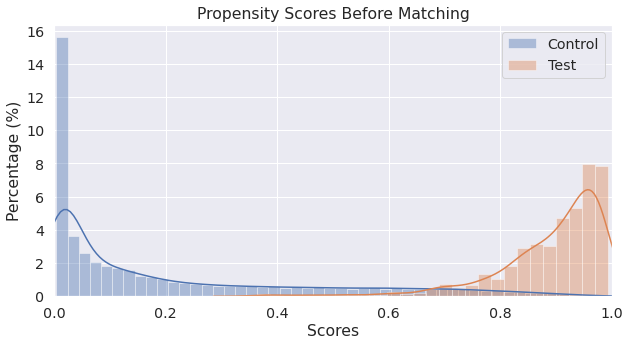

In [63]:
m.predict_scores()
m.plot_scores()

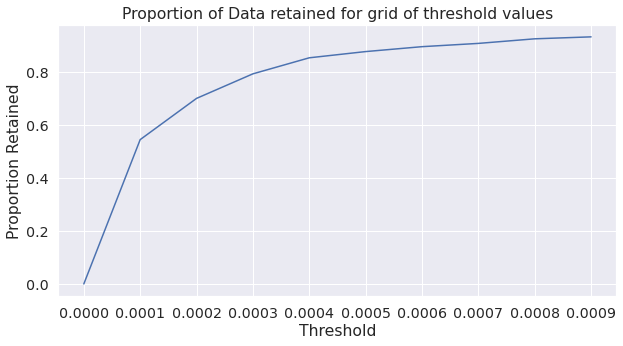

In [64]:
m.tune_threshold(method='random')

In [65]:
m.match(method="min", nmatches=1, threshold=0.0009)

In [66]:
m.matched_data.sort_values("match_id")

,AFIB_rate,CAD_rate,CPD_or_COPD_rate,Gender,MICU,Maligancy_rate,Renal_rate,adm_weekday,age,bicarbonate,...,stay_id,temperature_mean,troponin,vasopressor_use,ventilation_use,wbc,weight,scores,match_id,record_id
0,0.0,1.0,0.0,0,1,0.0,0.0,3,91,23.500000,...,30419609,36.805000,1.000000,0,1.0,15.900000,68.7,0.702346,0,0
14874,0.0,0.0,0.0,1,0,0.0,0.0,4,59,27.529412,...,39393117,36.744681,1.000000,1,1.0,6.085714,77.9,0.702349,0,14874
1,0.0,0.0,0.0,0,1,0.0,0.0,5,18,27.000000,...,30905391,37.887143,0.000000,0,0.0,4.650000,67.5,0.797434,1,1
34160,1.0,0.0,0.0,0,0,0.0,0.0,1,91,24.181818,...,38455362,37.308667,1.000000,1,1.0,14.440000,66.0,0.797374,1,34160
2,1.0,1.0,0.0,0,1,0.0,0.0,3,91,18.500000,...,34118048,36.797857,0.000000,1,0.0,10.480000,65.5,0.917741,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14440,1.0,1.0,1.0,0,0,0.0,0.0,4,59,33.611111,...,32935029,37.060182,0.000000,1,1.0,13.006667,116.0,0.804565,807,14440
808,1.0,0.0,0.0,1,1,1.0,1.0,5,91,16.400000,...,38011202,36.657647,1.000000,0,1.0,31.842857,60.0,0.910174,808,808
10294,0.0,0.0,0.0,0,0,0.0,0.0,4,52,22.000000,...,39952814,36.730000,0.000000,1,1.0,15.200000,64.4,0.909980,808,10294
809,1.0,0.0,0.0,1,1,0.0,0.0,5,91,22.181818,...,39446578,36.530370,0.666667,1,1.0,31.280000,63.2,0.804519,809,809


### Third Way

In [67]:
X = table_init.drop(['stay_id', 'modality', 'midodrine_injection'], axis=1)
y = table_init['midodrine_injection']

In [68]:
from sklearn.model_selection import train_test_split 
seed = 20220614 #for reproducible results
test_size=0.2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [69]:
from sklearn.metrics import accuracy_score

#instantiate model and train
model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)

XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=300)

In [70]:
# make predictions for test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.72%


In [71]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    model = XGBClassifier(n_estimators=300, learning_rate=learning_rate, max_features=2, max_depth=5, random_state=seed)
    model.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(model.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(model.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.987
Accuracy score (validation): 0.977
Learning rate:  0.075
Accuracy score (training): 0.991
Accuracy score (validation): 0.978
Learning rate:  0.1
Accuracy score (training): 0.996
Accuracy score (validation): 0.978
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.978
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.978
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.978
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.979


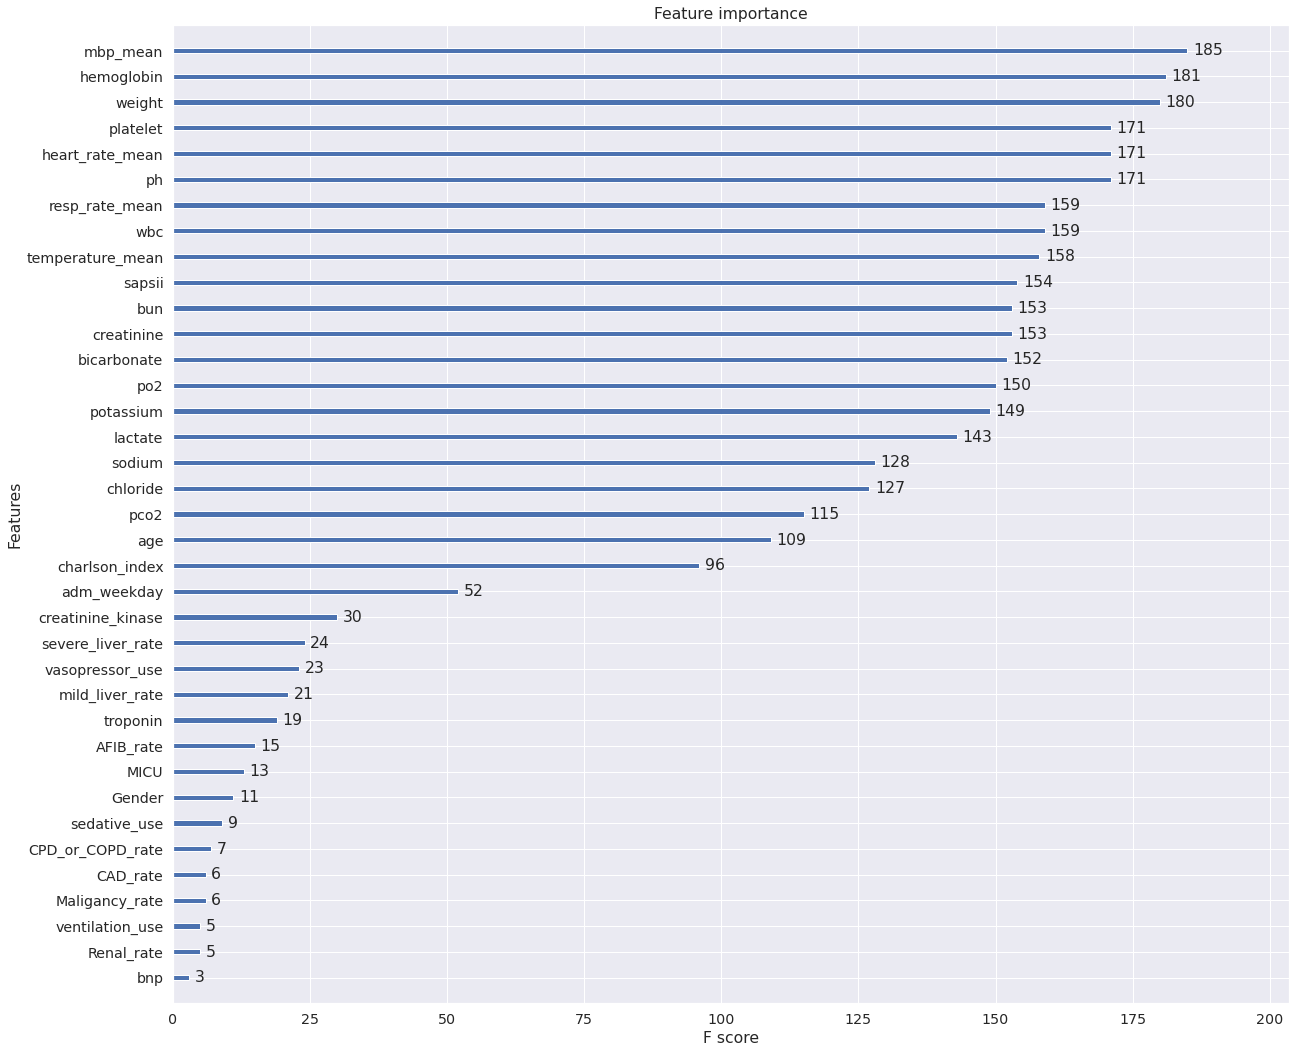

In [75]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
fig, ax = plt.subplots(figsize=(20,18))
plot_importance(model, ax=ax)
plt.show()

## TMLE on unweighted cohort

In [76]:
import statsmodels.api as sm

In [77]:
# SuperLearner setup
labels = ["LogR", "Step.int", "RandFor"]
candidates = [GLMSL(sm.families.family.Binomial()), 
              StepwiseSL(sm.families.family.Binomial(), selection="forward", order_interaction=0),
              XGBClassifier()]

TMLE on cohort table with missing values

In [78]:
tml =  TMLE(table_init, exposure='midodrine_injection', outcome='modality')

In [79]:
tmle =  TMLE(table_fillna, exposure='midodrine_injection', outcome='modality')

In [80]:
tml.exposure_model('age + MICU + Gender + adm_weekday + weight + sapsii + charlson_index + CPD_or_COPD_rate + Maligancy_rate + mild_liver_rate + severe_liver_rate + Renal_rate + CAD_rate + AFIB_rate + hemoglobin + platelet + wbc + sodium + potassium + bicarbonate + chloride + bun + creatinine + lactate + ph + po2 + pco2 + bnp + troponin + creatinine_kinase + temperature_mean + heart_rate_mean + resp_rate_mean + mbp_mean + sedative_use + ventilation_use + vasopressor_use',
                  bound=0.01 )  

Propensity Score Model
                  Generalized Linear Model Regression Results                  
Dep. Variable:     midodrine_injection   No. Observations:                14904
Model:                             GLM   Df Residuals:                    14866
Model Family:                 Binomial   Df Model:                           37
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -1766.3
Date:                 Sun, 19 Jun 2022   Deviance:                       3532.6
Time:                         00:02:03   Pearson chi2:                 1.55e+04
No. Iterations:                      8                                         
Covariance Type:             nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Inter

In [81]:
tml.outcome_model('age + MICU + Gender + adm_weekday + weight + sapsii + charlson_index + CPD_or_COPD_rate + Maligancy_rate + mild_liver_rate + severe_liver_rate + Renal_rate + CAD_rate + AFIB_rate + hemoglobin + platelet + wbc + sodium + potassium + bicarbonate + chloride + bun + creatinine + lactate + ph + po2 + pco2 + bnp + troponin + creatinine_kinase + temperature_mean + heart_rate_mean + resp_rate_mean + mbp_mean + sedative_use + ventilation_use + vasopressor_use',
                  bound=0.01 )

Outcome Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:               modality   No. Observations:                14904
Model:                            GLM   Df Residuals:                    14866
Model Family:                Binomial   Df Model:                           37
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6159.4
Date:                Sun, 19 Jun 2022   Deviance:                       12319.
Time:                        00:02:04   Pearson chi2:                 1.44e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -40.

In [82]:
tml.fit() 

In [83]:
tml.summary()

                Targeted Maximum Likelihood Estimator                 
Treatment:        midodrine_injection No. Observations:     14904               
Outcome:          modality        No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Q-Model:          Logistic       
Risk Difference:     -0.003
95.0% two-sided CI: (-0.041 , 0.036)
----------------------------------------------------------------------
Risk Ratio:          0.989
95.0% two-sided CI: (0.829 , 1.18)
----------------------------------------------------------------------
Odds Ratio:          0.986
95.0% two-sided CI: (0.786 , 1.236)


	Exposure Model Diagnostics
                   Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be 2
----------------------------------------------------------------------
Mean weight:            1.724
Standard Deviation:     6.063
Minimum weight:         1.01
Maximum weight:         100.0

                  Standardized Mean Differences
                      smd_w     smd_u
labels                               
age                0.130173 -0.012593
MICU               0.045060  0.166354
Gender             0.003124 -0.038396
adm_weekday       -0.003819 -0.041730
weight            -0.128659  0.153808
sapsii             0.212543  0.530177
charlson_index     0.173918  0.385344
CPD_or_COPD_rate   0.136001 -0.053507
Maligancy_rate    -0.001235 -0.047430
mild_liver_rate    0.052671  0.875997
severe_liver_rate  0.092742  0.979438
Renal_rate         0.093446  0.26

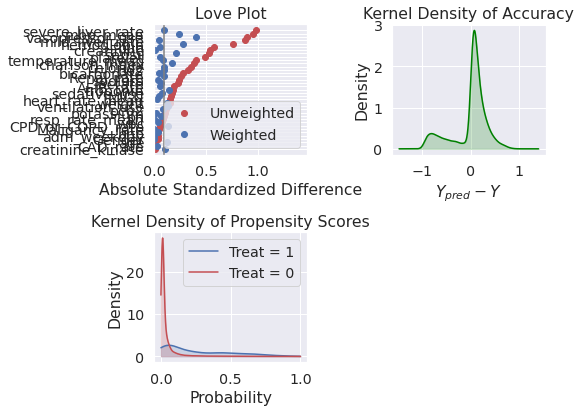

In [84]:
tml.run_diagnostics()

TMLE on imputed cohort table

In [85]:
tmle.exposure_model('age + MICU + Gender + adm_weekday + weight + sapsii + charlson_index + CPD_or_COPD_rate + Maligancy_rate + mild_liver_rate + severe_liver_rate + Renal_rate + CAD_rate + AFIB_rate + hemoglobin + platelet + wbc + sodium + potassium + bicarbonate + chloride + bun + creatinine + lactate + ph + po2 + pco2 + bnp + troponin + creatinine_kinase + temperature_mean + heart_rate_mean + resp_rate_mean + mbp_mean + sedative_use + ventilation_use + vasopressor_use',
                  bound=0.01 )  

Propensity Score Model
                  Generalized Linear Model Regression Results                  
Dep. Variable:     midodrine_injection   No. Observations:                35300
Model:                             GLM   Df Residuals:                    35262
Model Family:                 Binomial   Df Model:                           37
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -2664.5
Date:                 Sun, 19 Jun 2022   Deviance:                       5329.0
Time:                         00:02:20   Pearson chi2:                 3.93e+04
No. Iterations:                      8                                         
Covariance Type:             nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Inter

In [86]:
tmle.outcome_model('age + MICU + Gender + adm_weekday + weight + sapsii + charlson_index + CPD_or_COPD_rate + Maligancy_rate + mild_liver_rate + severe_liver_rate + Renal_rate + CAD_rate + AFIB_rate + hemoglobin + platelet + wbc + sodium + potassium + bicarbonate + chloride + bun + creatinine + lactate + ph + po2 + pco2 + bnp + troponin + creatinine_kinase + temperature_mean + heart_rate_mean + resp_rate_mean + mbp_mean + sedative_use + ventilation_use + vasopressor_use',
                  bound=0.01 )

Outcome Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:               modality   No. Observations:                35300
Model:                            GLM   Df Residuals:                    35262
Model Family:                Binomial   Df Model:                           37
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12596.
Date:                Sun, 19 Jun 2022   Deviance:                       25191.
Time:                        00:02:21   Pearson chi2:                 3.41e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.

In [87]:
tml.fit()

In [88]:
 tml.summary()

                Targeted Maximum Likelihood Estimator                 
Treatment:        midodrine_injection No. Observations:     14904               
Outcome:          modality        No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Q-Model:          Logistic       
Risk Difference:     -0.003
95.0% two-sided CI: (-0.041 , 0.036)
----------------------------------------------------------------------
Risk Ratio:          0.989
95.0% two-sided CI: (0.829 , 1.18)
----------------------------------------------------------------------
Odds Ratio:          0.986
95.0% two-sided CI: (0.786 , 1.236)


	Exposure Model Diagnostics
                   Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be 2
----------------------------------------------------------------------
Mean weight:            1.724
Standard Deviation:     6.063
Minimum weight:         1.01
Maximum weight:         100.0

                  Standardized Mean Differences
                      smd_w     smd_u
labels                               
age                0.130173 -0.012593
MICU               0.045060  0.166354
Gender             0.003124 -0.038396
adm_weekday       -0.003819 -0.041730
weight            -0.128659  0.153808
sapsii             0.212543  0.530177
charlson_index     0.173918  0.385344
CPD_or_COPD_rate   0.136001 -0.053507
Maligancy_rate    -0.001235 -0.047430
mild_liver_rate    0.052671  0.875997
severe_liver_rate  0.092742  0.979438
Renal_rate         0.093446  0.26

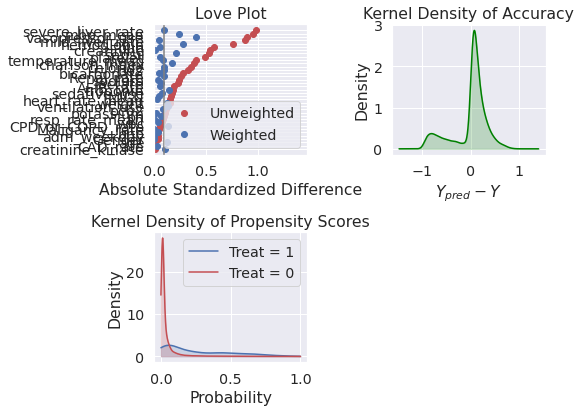

In [89]:
 tml.run_diagnostics()

## Extract matched no-midodrine data
Here I use the first way

In [ ]:
nomid_matched = table_init[table_init['stay_id'].isin(psm.matched_ids['matched_ID'])]

In [ ]:
nomid_matched.describe()

In [ ]:
nomid_group.describe()

In [ ]:
psm.effect_size

## Save the results

In [ ]:
mid_group.describe().to_csv('/content/drive/MyDrive/midodrine_table1_results/mid_group.csv')
nomid_group.describe().to_csv('/content/drive/MyDrive/midodrine_table1_results/nomid_group.csv')
nomid_matched.describe().to_csv('/content/drive/MyDrive/midodrine_table1_results/nomid_matched.csv')
psm.effect_size.to_csv('/content/drive/MyDrive/midodrine_table1_results/psm_effect_size.csv')